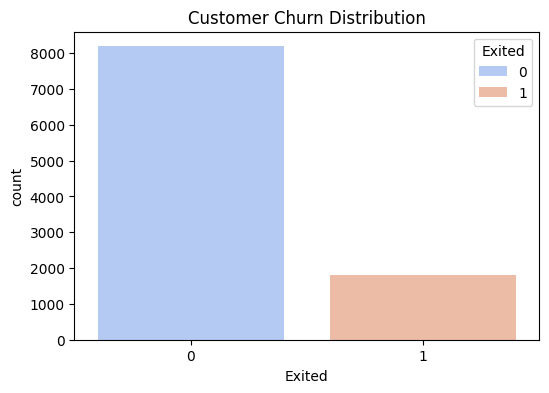

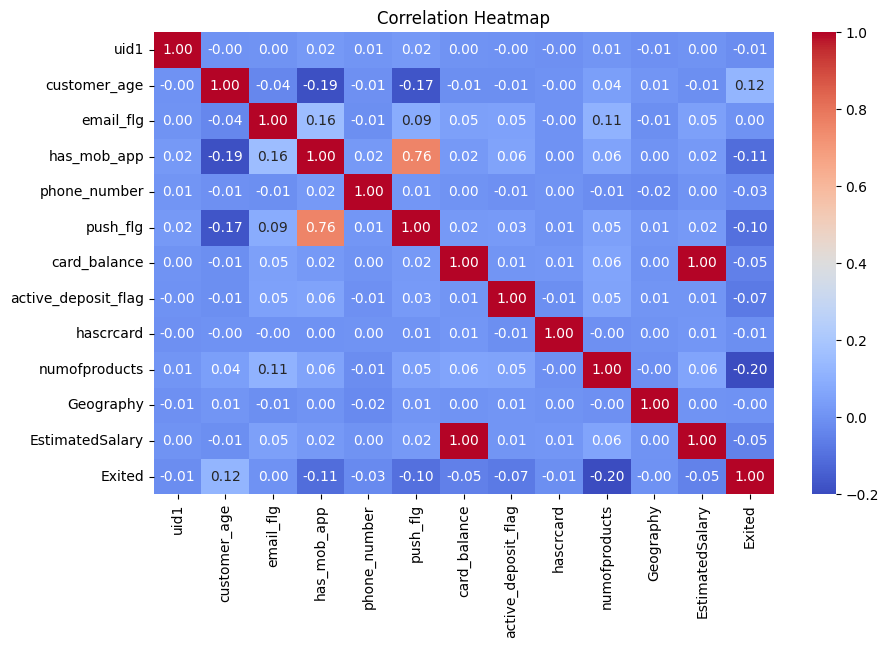

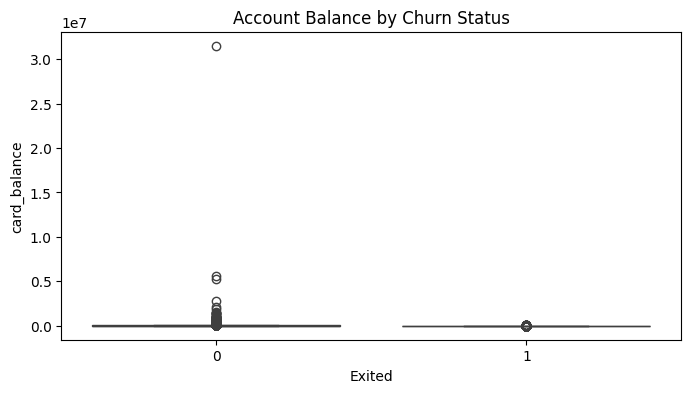

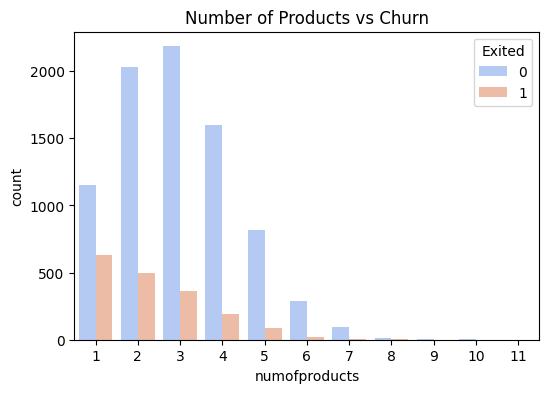


Summary Statistics:

+----------+----------------+----------------+-----------------+-------------------+
|   Exited |   customer_age |   card_balance |   numofproducts |   EstimatedSalary |
+==========+================+================+=================+===================+
|        0 |        41.4472 |       46815.8  |         3.03248 |          375583   |
+----------+----------------+----------------+-----------------+-------------------+
|        1 |        47.8853 |        1520.53 |         2.29268 |           29930.1 |
+----------+----------------+----------------+-----------------+-------------------+

Short Summary Statistics:

+----------+----------------+----------------+
|   Exited |   customer_age |   card_balance |
+==========+================+================+
|        0 |        41.4472 |       46815.8  |
+----------+----------------+----------------+
|        1 |        47.8853 |        1520.53 |
+----------+----------------+----------------+

High-Risk Churn Customers

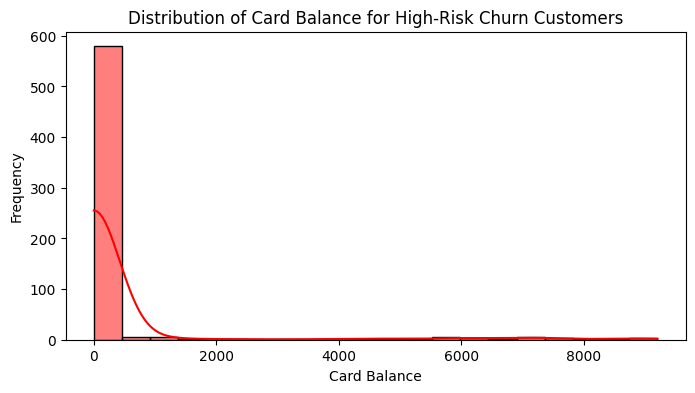


Hypothesis: Customers with lower engagement are more likely to churn
Median balance for churned customers: 0.0
Median balance for retained customers: 16189.6
T-test for balance differences: t=-11.087, p=0.00000

All tables have been printed and exported to /content/Customer_Churn_Analysis.xlsx


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tabulate import tabulate

csv_path = "/content/customer churn analysis.csv"
xlsx_path = "/content/Data base from CSV file.xlsx"
output_xlsx_path = "/content/Customer_Churn_Analysis.xlsx"

df_csv = pd.read_csv(csv_path, delimiter=';')
df_xlsx = pd.read_excel(xlsx_path, sheet_name=0)

df_csv['registration_dt'] = pd.to_datetime(df_csv['registration_dt'], errors='coerce')
df_xlsx['registration_dt'] = pd.to_datetime(df_xlsx['registration_dt'], errors='coerce')

df_csv.fillna({'customer_age': df_csv['customer_age'].median()}, inplace=True)
df_xlsx.fillna({'customer_age': df_xlsx['customer_age'].median()}, inplace=True)

df_csv['Geography'] = df_csv['Geography'].astype('category').cat.codes
df_xlsx['Geography'] = df_xlsx['Geography'].astype('category').cat.codes

plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=df_xlsx, hue='Exited', palette="coolwarm")
plt.title("Customer Churn Distribution")
plt.show()

numeric_cols = df_xlsx.select_dtypes(include=['number']).columns
plt.figure(figsize=(10,6))
sns.heatmap(df_xlsx[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='Exited', y='card_balance', data=df_xlsx)
plt.title("Account Balance by Churn Status")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='numofproducts', hue='Exited', data=df_xlsx, palette="coolwarm")
plt.title("Number of Products vs Churn")
plt.show()

if 'num_complaints' in df_xlsx.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='num_complaints', hue='Exited', data=df_xlsx, palette="coolwarm")
    plt.title("Customer Complaints vs Churn")
    plt.show()

if 'EmploymentType' in df_xlsx.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='EmploymentType', y='EstimatedSalary', hue='Exited', data=df_xlsx)
    plt.title("Employment Type vs Salary (Churned vs Non-Churned)")
    plt.show()

if 'transaction_frequency' in df_xlsx.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Exited', y='transaction_frequency', data=df_xlsx)
    plt.title("Transaction Frequency vs Churn")
    plt.show()

summary_stats = df_xlsx.groupby('Exited')[['customer_age', 'card_balance', 'numofproducts', 'EstimatedSalary']].mean()
print("\nSummary Statistics:\n")
print(tabulate(summary_stats, headers='keys', tablefmt='grid'))

short_summary_stats = summary_stats[['customer_age', 'card_balance']]
print("\nShort Summary Statistics:\n")
print(tabulate(short_summary_stats, headers='keys', tablefmt='grid'))

def identify_high_risk(df):
    return df[(df['numofproducts'] == 1) & (df['card_balance'] < df['card_balance'].median()) & (df['Exited'] == 1)]

high_risk_customers = identify_high_risk(df_xlsx)
print("\nHigh-Risk Churn Customers (Top 10 rows):\n")
print(tabulate(high_risk_customers.head(10), headers='keys', tablefmt='grid'))

short_high_risk_customers = high_risk_customers[['card_balance']].head(10)
if 'customer_id' in high_risk_customers.columns:
    short_high_risk_customers = high_risk_customers[['customer_id', 'card_balance']].head(10)
    print("\nShort High-Risk Customers:\n")
    print(tabulate(short_high_risk_customers, headers='keys', tablefmt='grid'))

high_risk_summary = high_risk_customers.describe()
print("\nHigh-Risk Customers Summary:\n")
print(tabulate(high_risk_summary, headers='keys', tablefmt='grid'))

plt.figure(figsize=(8,4))
sns.histplot(high_risk_customers['card_balance'], bins=20, kde=True, color='red')
plt.title("Distribution of Card Balance for High-Risk Churn Customers")
plt.xlabel("Card Balance")
plt.ylabel("Frequency")
plt.show()

def hypothesis_test(df):
    print("\nHypothesis: Customers with lower engagement are more likely to churn")
    print("Median balance for churned customers:", df[df['Exited'] == 1]['card_balance'].median())
    print("Median balance for retained customers:", df[df['Exited'] == 0]['card_balance'].median())

    churned_balances = df[df['Exited'] == 1]['card_balance']
    retained_balances = df[df['Exited'] == 0]['card_balance']
    t_stat, p_val = stats.ttest_ind(churned_balances, retained_balances, equal_var=False)
    print(f"T-test for balance differences: t={t_stat:.3f}, p={p_val:.5f}")

    return pd.DataFrame({'T-Statistic': [t_stat], 'P-Value': [p_val]})

hypothesis_results = hypothesis_test(df_xlsx)


with pd.ExcelWriter(output_xlsx_path) as writer:
    summary_stats.to_excel(writer, sheet_name="Summary Statistics")
    short_summary_stats.to_excel(writer, sheet_name="Short Summary Statistics")
    high_risk_customers.to_excel(writer, sheet_name="High-Risk Customers")
    short_high_risk_customers.to_excel(writer, sheet_name="Short High-Risk Customers")
    high_risk_summary.to_excel(writer, sheet_name="High-Risk Customers Summary")
    hypothesis_results.to_excel(writer, sheet_name="Hypothesis Test")

print(f"\nAll tables have been printed and exported to {output_xlsx_path}")
